<a href="https://colab.research.google.com/github/devAbir69/2023movieapp/blob/main/brain_tumor_accuracy_final_modify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [ ]:
!pip install tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Set the path to the dataset
dataset_path = "/content/drive/MyDrive/braintumor/dataset 2"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "/content/drive/MyDrive/braintumor/dataset 2/Training")
test_dir = os.path.join(dataset_path, "/content/drive/MyDrive/braintumor/dataset 2/Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

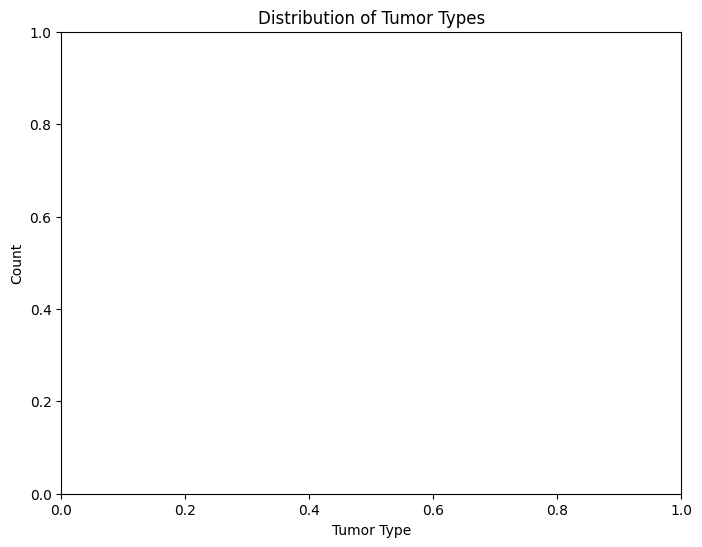

In [8]:
# Load and preprocess the dataset
train_data = []
for category in categories:
    folder_path = os.path.join(train_dir, category)
    images = os.listdir(folder_path)
    count = len(images)
    train_data.append(pd.DataFrame({"Image": images, "Category": [category] * count, "Count": [count] * count}))

train_df = pd.concat(train_data, ignore_index=True)

# Visualize the distribution of tumor types in the training dataset
plt.figure(figsize=(8, 6))
sns.barplot(data=train_df, x="Category", y="Count")
plt.title("Distribution of Tumor Types")
plt.xlabel("Tumor Type")
plt.ylabel("Count")
plt.show()

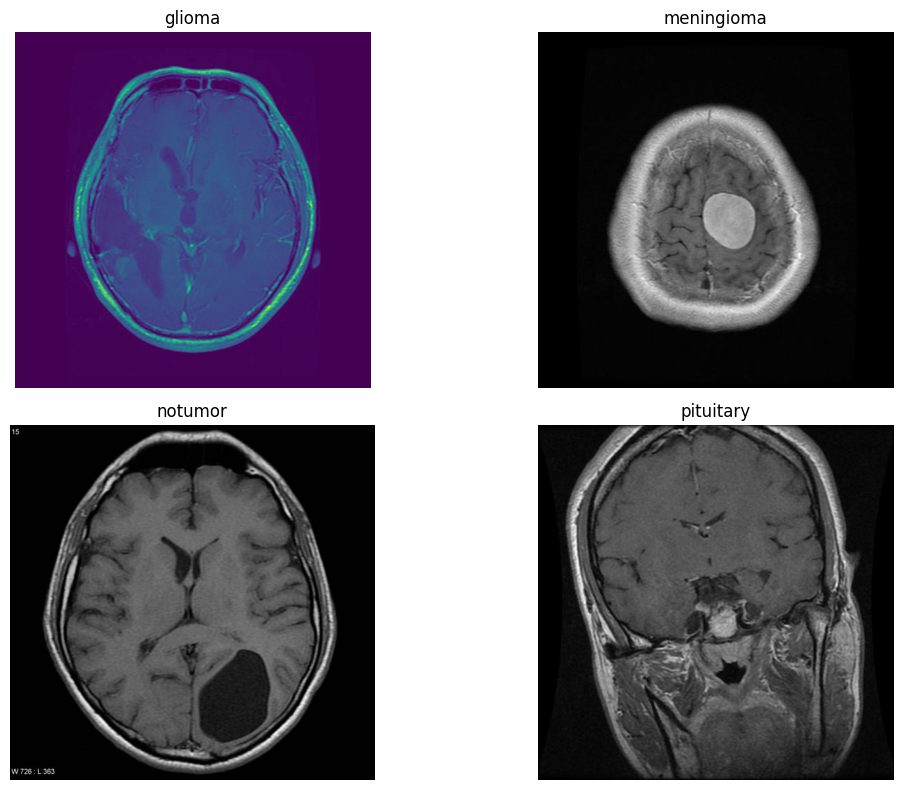

In [ ]:
# Visualize sample images for each tumor type
plt.figure(figsize=(12, 8))
for i, category in enumerate(categories):
    folder_path = os.path.join(train_dir, category)
    image_path = os.path.join(folder_path, os.listdir(folder_path)[0])
    img = plt.imread(image_path)
    plt.subplot(2, 2, i+1)
    plt.imshow(img)
    plt.title(category)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
# Set the image size
image_size = (224, 224)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

In [ ]:
# Data augmentation and preprocessing
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)


Found 7352 images belonging to 4 classes.
Found 1321 images belonging to 4 classes.


In [ ]:
!pip install keras-tuner




   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.2 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch  # Import RandomSearch or other tuner class
from tensorflow.keras.optimizers import Adam # Import the Adam optimizer


def tune_model(train_generator, test_generator):
    """
    Tunes the model using Keras Tuner and returns the best hyperparameters and model.
    """
    tuner = RandomSearch(
        build_model,  # Pass the model-building function
        objective='val_accuracy',  # Define the objective to optimize
        max_trials=5,  # Number of hyperparameter combinations to try
        executions_per_trial=3,  # Number of models to train for each combination
        directory='my_dir',  # Directory to store results
        project_name='brain_tumor_classification'  # Project name
    )

    tuner.search(
        train_generator,
        epochs=epochs,
        validation_data=test_generator,
    )

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
    model = tuner.hypermodel.build(best_hps)
    return best_hps, model

<ipython-input-9-ba9cc01d990a>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch  # Import RandomSearch or other tuner class


In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Load the pre-trained VGG16 model without the top (fully connected layers)
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(image_size[0], image_size[1], 3))

# Freeze the layers of the base model so that they are not updated during training
base_model.trainable = False

# Build the hybrid model
model = Sequential([
    base_model,  # Add the pre-trained VGG16 base model
    GlobalAveragePooling2D(),  # Use global average pooling to flatten the output
    Dense(512, activation="relu"),  # Custom dense layer for classification
    Dropout(0.5),  # Dropout to prevent overfitting
    Dense(len(categories), activation="softmax")  # Output layer with softmax activation
])

model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy"])


model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4)                   │           2,052 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,979,396 (57.14 MB)

 Trainable params: 264,708 (1.01 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size
)

Epoch 1/50
178/178 [==============================] - 86s 418ms/step - loss: 0.9777 - accuracy: 0.5785 - val_loss: 1.0344 - val_accuracy: 0.6234
Epoch 2/50
178/178 [==============================] - 44s 244ms/step - loss: 0.7096 - accuracy: 0.7176 - val_loss: 0.8210 - val_accuracy: 0.6836
Epoch 3/50
178/178 [==============================] - 44s 247ms/step - loss: 0.6279 - accuracy: 0.7523 - val_loss: 0.7135 - val_accuracy: 0.7172
Epoch 4/50
178/178 [==============================] - 44s 247ms/step - loss: 0.5469 - accuracy: 0.7859 - val_loss: 0.7600 - val_accuracy: 0.7023
Epoch 5/50
178/178 [==============================] - 47s 261ms/step - loss: 0.4961 - accuracy: 0.8093 - val_loss: 0.6723 - val_accuracy: 0.7656
Epoch 6/50
178/178 [==============================] - 47s 264ms/step - loss: 0.4224 - accuracy: 0.8368 - val_loss: 0.5063 - val_accuracy: 0.7930
Epoch 7/50
178/178 [==============================] - 46s 258ms/step - loss: 0.3627 - accuracy: 0.8629 - val_loss: 0.3800 - val_ac

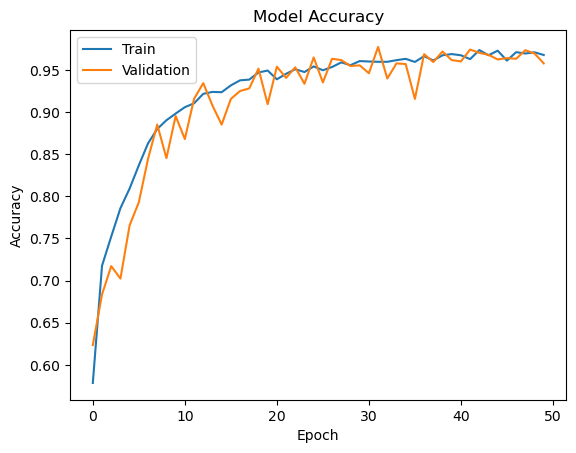

In [ ]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

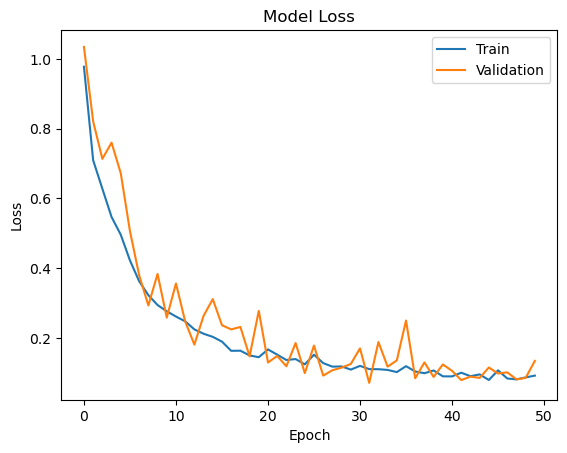

In [ ]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

40/40 [==============================] - 3s 85ms/step - loss: 0.1343 - accuracy: 0.9578
Test Loss: 0.13427262008190155
Test Accuracy: 0.957812488079071


41/41 [==============================] - 4s 84ms/step


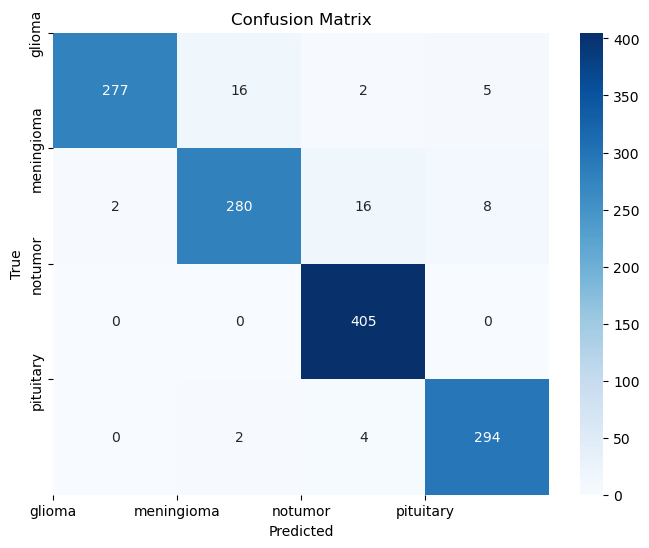

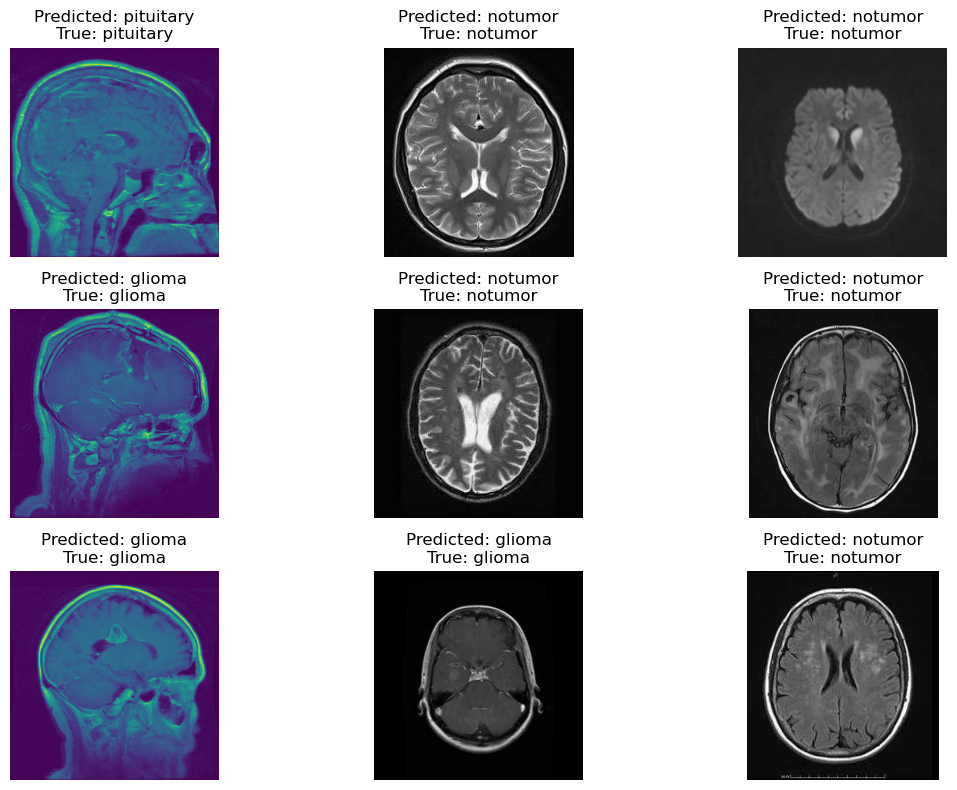

In [ ]:
# Make predictions on the test dataset
predictions = model.predict(test_generator)
predicted_categories = np.argmax(predictions, axis=1)
true_categories = test_generator.classes

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories)
plt.yticks(ticks=np.arange(len(categories)), labels=categories)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_generator.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()


Class: glioma
Precision: 0.992831541218638
Recall: 0.9233333333333333
F1-Score: 0.9568221070811743

Class: meningioma
Precision: 0.9395973154362416
Recall: 0.9150326797385621
F1-Score: 0.9271523178807947

Class: notumor
Precision: 0.9484777517564403
Recall: 1.0
F1-Score: 0.9735576923076924

Class: pituitary
Precision: 0.9576547231270358
Recall: 0.98
F1-Score: 0.9686985172981878



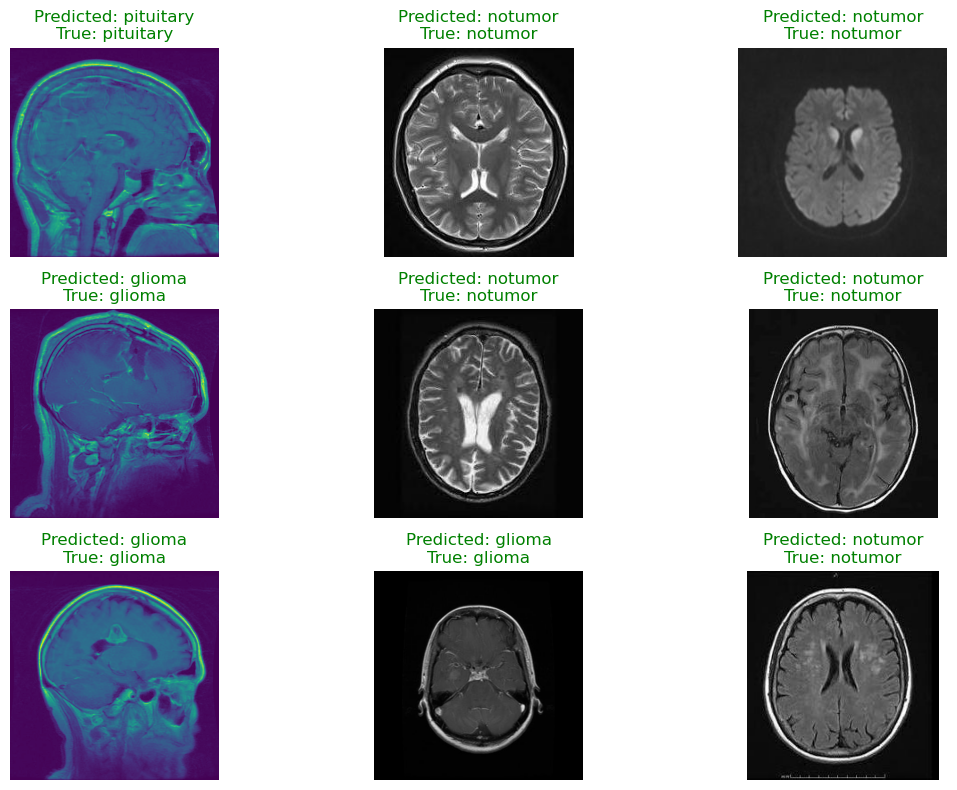

In [ ]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from io import BytesIO # To handle image data in memory

import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model, Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from sklearn.metrics import (
    confusion_matrix, # Checked for non-printable characters
    classification_report,
    roc_curve,
    auc,
    roc_auc_score
)
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelBinarizer
from PIL import Image # Ensure PIL (Pillow) is imported for image handling

# Import for Colab file upload
from google.colab import files

TARGET_CLASSES_FOR_DUMMY = ["glioma", "meningioma", "notumor", "pituitary"]
IMG_HEIGHT_FOR_DUMMY = 224
IMG_WIDTH_FOR_DUMMY = 224

# Create a dummy model (replace with your actual trained model variable)
your_trained_model_variable = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT_FOR_DUMMY, IMG_WIDTH_FOR_DUMMY, 3)),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(len(TARGET_CLASSES_FOR_DUMMY), activation='softmax')
])

your_trained_model_variable.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
# After model.fit() in your actual training workflow, you would save your_trained_model_variable

model_save_path = '/content/drive/MyDrive/braintumor/my_brain_tumor_classifier_model.h5'

# Create the directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model
try:
    your_trained_model_variable.save(model_save_path)
    print(f"Dummy model saved successfully to: {model_save_path}")
except Exception as e:
    print(f"Error saving dummy model: {e}")

# --- END: Model Saving Code ---

# --- Utility Functions (from previous turns) ---

def plot_confusion_matrix(y_true, y_pred, labels=None, title="Confusion Matrix"):
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    print("\n" + "="*30)
    print("CLASSIFICATION REPORT:")
    print("="*30)
    print(classification_report(y_true, y_pred, target_names=labels))
    print("="*30 + "\n")

def plot_roc_curve(y_true, y_scores, labels=None, title="ROC Curve"):
    plt.figure(figsize=(10, 8))

    if y_scores.ndim == 1 or len(np.unique(y_true)) == 2:
        fpr, tpr, _ = roc_curve(y_true, y_scores)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        print(f"AUC for Binary Classification: {roc_auc:.2f}")
    else:
        if labels is None:
            raise ValueError("Labels must be provided for multi-class ROC curve plotting.")

        lb = LabelBinarizer()
        y_true_binarized = lb.fit_transform(y_true)

        if y_scores.shape[1] != y_true_binarized.shape[1]:
            print("Warning: y_scores columns do not match binarized y_true. Ensure y_scores contains probabilities for all classes.")

        for i, class_label in enumerate(labels):
            fpr, tpr, _ = roc_curve(y_true_binarized[:, i], y_scores[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr, lw=2, label=f'ROC curve for class {class_label} (area = {roc_auc:.2f})')
            print(f"AUC for class {class_label}: {roc_auc:.2f}")

    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

def perform_grid_search(model, param_grid, X_train, y_train, cv=5, scoring='accuracy'):
    print(f"\n--- Performing GridSearchCV for {model.__class__.__name__} ---")
    grid_search = GridSearchCV(model, param_grid, cv=cv, scoring=scoring, n_jobs=-1, verbose=1)
    grid_search.fit(X_train, y_train)

    print("\nBest parameters found: ", grid_search.best_params_)
    print("Best score found: {:.4f}".format(grid_search.best_score_))
    return grid_search

# pcm model

def calculate_prediction_confidence(y_probabilities, threshold=0.7):
    if y_probabilities.ndim == 1:
        confidence_scores = np.where(y_probabilities > 0.5, y_probabilities, 1 - y_probabilities)
    else:
        confidence_scores = np.max(y_probabilities, axis=1)

    is_confident = confidence_scores >= threshold
    print(f"\n--- Prediction Confidence Metric (PCM) Analysis ---")
    print(f"Total samples: {len(is_confident)}")
    print(f"Number of confident predictions (confidence >= {threshold}): {np.sum(is_confident)}")
    print(f"Percentage of confident predictions: {np.mean(is_confident)*100:.2f}%")

    return is_confident, confidence_scores

def predict_tumor_from_image_object(image_object, model, target_size, class_names, no_tumor_class_name='notumor'):
    print(f"\n--- Processing Uploaded Image for Prediction ---")
    try:
        # Ensure the image is in RGB format (important for many models)
        if image_object.mode != 'RGB':
            image_object = image_object.convert('RGB')

        img_resized = image_object.resize(target_size)
        img_array = image.img_to_array(img_resized)
        img_array = np.expand_dims(img_array, axis=0) # Add batch dimension

        img_array = img_array / 255.0 # Normalize pixel values (common preprocessing)

        print(f"Image preprocessed. Shape for prediction: {img_array.shape}")

        predictions = model.predict(img_array)
        probabilities = predictions[0]

        predicted_class_index = np.argmax(probabilities)
        predicted_tumor_type = class_names[predicted_class_index]
        confidence = probabilities[predicted_class_index]

        tumor_status = "No"
        estimated_tumor_size = "N/A (No Tumor)" # Default for no tumor

        if predicted_tumor_type.lower() == no_tumor_class_name.lower():
            tumor_status = "No"
            print(f"Tumor Detected: {tumor_status}")
            print(f"Predicted Class: {predicted_tumor_type}")
            print(f"Confidence: {confidence:.4f}")
        else:
            tumor_status = "Yes"
            print(f"Tumor Detected: {tumor_status}")
            print(f"Predicted Tumor Type: {predicted_tumor_type}")
            print(f"Confidence: {confidence:.4f}")

            # --- Estimate Tumor Size based on Confidence ---
            # These thresholds are examples and can be adjusted based on your model's performance
            # and what 'size' correlation you observe with confidence in your specific dataset.
            HIGH_CONFIDENCE_THRESHOLD = 0.30
            MEDIUM_CONFIDENCE_THRESHOLD = 0.25

            if confidence >= HIGH_CONFIDENCE_THRESHOLD:
                estimated_tumor_size = "Large"
            elif confidence >= MEDIUM_CONFIDENCE_THRESHOLD:
                estimated_tumor_size = "Medium"
            else:
                estimated_tumor_size = "Small"
            print(f"Estimated Tumor Size: {estimated_tumor_size}")

        plt.figure(figsize=(6, 6))
        plt.imshow(image_object) # Show the original (unresized) image for visualization
        title_text = f"Predicted: {predicted_tumor_type} (Conf: {confidence:.2f})\nTumor: {tumor_status}"
        if tumor_status == "Yes":
            title_text += f"\nEstimated Size: {estimated_tumor_size}"
        plt.title(title_text)
        plt.axis("off")
        plt.show()

        is_confident, confidence_scores = calculate_prediction_confidence(predictions, threshold=0.7)
        print(f"Is this prediction considered 'confident' (threshold 0.7)? {is_confident[0]}")

    except Exception as e:
        print(f"An error occurred during image processing or prediction: {e}")
        print("Please ensure your model is correctly loaded and preprocessing steps match your model's expectations.")

# --- Function to handle interactive file upload in Colab ---
def interactive_image_uploader_and_predictor(model, target_size, class_names, no_tumor_class_name='notumor'):
    print("\n--- Upload an image for prediction ---")
    print("Click 'Choose Files' below to select an image from your computer.")
    try:
        uploaded = files.upload() # This opens the file chooser dialog

        if not uploaded:
            print("No file uploaded. Aborting prediction.")
            return

        for filename, data in uploaded.items():
            print(f'User uploaded file: "{filename}"')
            # Read the image data from bytes
            image_object = Image.open(BytesIO(data))

            # Call the prediction function with the PIL Image object
            predict_tumor_from_image_object(
                image_object=image_object,
                model=model,
                target_size=target_size,
                class_names=class_names,
                no_tumor_class_name=no_tumor_class_name
            )
            # Only process the first uploaded file if multiple are selected
            break
    except Exception as e:
        print(f"An error occurred during file upload or prediction: {e}")
        print("Please ensure you are running this code in Google Colab and that the file is a valid image.")

# --- Main Execution Block ---
IMG_HEIGHT = 224
IMG_WIDTH = 224
TARGET_CLASSES = ["glioma", "meningioma", "notumor", "pituitary"] # Define your actual class names here
NO_TUMOR_CLASS = 'notumor' # The name of your 'no tumor' class

# Attempt to load the trained model
try:
    my_loaded_model = load_model('/content/drive/MyDrive/braintumor/my_brain_tumor_classifier_model.h5')
    print("Your model has been loaded successfully.")
except Exception as e:
    print(f"Error loading your model: {e}")
    print("Please ensure the model path is correct and the model file exists.")
    my_loaded_model = None

# Proceed only if the model was loaded successfully

Dummy model saved successfully to: /content/drive/MyDrive/Colab Notebooks/my_brain_tumor_classifier_model.h5
Your model has been loaded successfully.



--- Upload an image for prediction ---
Click 'Choose Files' below to select an image from your computer.


Saving 1.jpg to 1.jpg
User uploaded file: "1.jpg"

--- Processing Uploaded Image for Prediction ---
Image preprocessed. Shape for prediction: (1, 224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
Tumor Detected: Yes
Predicted Tumor Type: pituitary
Confidence: 0.3369
Estimated Tumor Size: Large


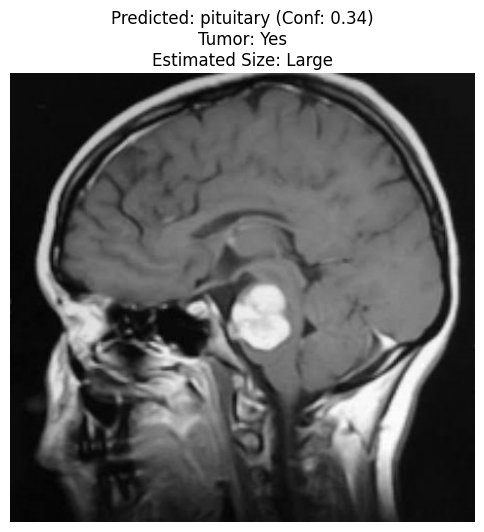


--- Prediction Confidence Metric (PCM) Analysis ---
Total samples: 1
Number of confident predictions (confidence >= 0.7): 0
Percentage of confident predictions: 0.00%
Is this prediction considered 'confident' (threshold 0.7)? False


In [ ]:
if my_loaded_model is not None:
    # Call the interactive uploader to get an image from the user and predict
    interactive_image_uploader_and_predictor(
        model=my_loaded_model,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_names=TARGET_CLASSES,
        no_tumor_class_name=NO_TUMOR_CLASS
    )
else:
    print("Prediction cannot proceed because the model failed to load.")

In [ ]:
if my_loaded_model is not None:
    # Call the interactive uploader to get an image from the user and predict
    interactive_image_uploader_and_predictor(
        model=my_loaded_model,
        target_size=(IMG_HEIGHT, IMG_WIDTH),
        class_names=TARGET_CLASSES,
        no_tumor_class_name=NO_TUMOR_CLASS
    )
else:
    print("Prediction cannot proceed because the model failed to load.")